# Dirichlet mixture of multinomial distributions for HTTP Error Codes

## The problem


Links that helped me build this:
1. https://www.pymc.io/projects/docs/en/v3.11.4/pymc-examples/examples/mixture_models/dirichlet_mixture_of_multinomials.html

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import scipy as sp
import scipy.stats
import seaborn as sns

In [3]:
true_conc = 6.0
true_frac = np.array([0.45, 0.30, 0.15, 0.09, 0.01])
k = len(true_frac)  # Number of different tree species observed
n = 10  # Number of forests observed
total_count = 50

true_p = sp.stats.dirichlet(true_conc * true_frac).rvs(size=n)
observed_counts = np.vstack([sp.stats.multinomial(n=total_count, p=p_i).rvs() for p_i in true_p])

observed_counts

array([[16, 19,  5,  7,  3],
       [37, 13,  0,  0,  0],
       [40,  3,  3,  4,  0],
       [19, 13,  1, 17,  0],
       [43,  6,  0,  1,  0],
       [31, 13,  4,  2,  0],
       [14,  5, 27,  0,  4],
       [42,  1,  7,  0,  0],
       [35, 12,  2,  1,  0],
       [30,  8,  0, 12,  0]])

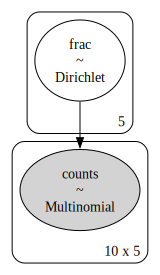

In [4]:
with pm.Model() as model_multinomial:
    frac = pm.Dirichlet("frac", a=np.ones(k))
    counts = pm.Multinomial("counts", n=total_count, p=frac, shape=(n, k), observed=observed_counts)

pm.model_to_graphviz(model_multinomial)

In [5]:
with model_multinomial:
    trace_multinomial = pm.sample(
        draws=int(5e3), chains=4, step=pm.Metropolis(), return_inferencedata=True
    )

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [frac]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.


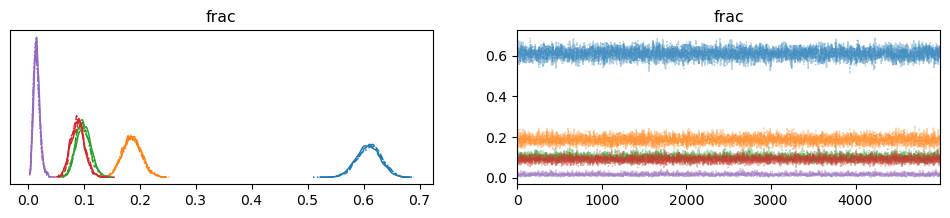

In [6]:
az.plot_trace(data=trace_multinomial, var_names=["frac"]);

In [7]:
summary_multinomial = az.summary(trace_multinomial, var_names=["frac"])
#summary_multinomial = summary_multinomial.assign(
#    ess_mean_per_sec=lambda x: x.ess_mean / trace_multinomial.posterior.sampling_time,
#)

summary_multinomial


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
frac[0],0.610,0.022,0.569,0.650,0.0,0.0,3565.0,4883.0,1.0
frac[1],0.186,0.017,0.154,0.218,0.0,0.0,3776.0,4399.0,1.0
frac[2],0.099,0.013,0.075,0.123,0.0,0.0,3183.0,3675.0,1.0
frac[3],0.089,0.013,0.067,0.113,0.0,0.0,3196.0,4381.0,1.0
frac[4],0.016,0.006,0.006,0.026,0.0,0.0,1396.0,2119.0,1.0


c:\Users\pboeh\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:
c:\Users\pboeh\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\forestplot.py:545: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  for _, sub_data in grouped_datum:


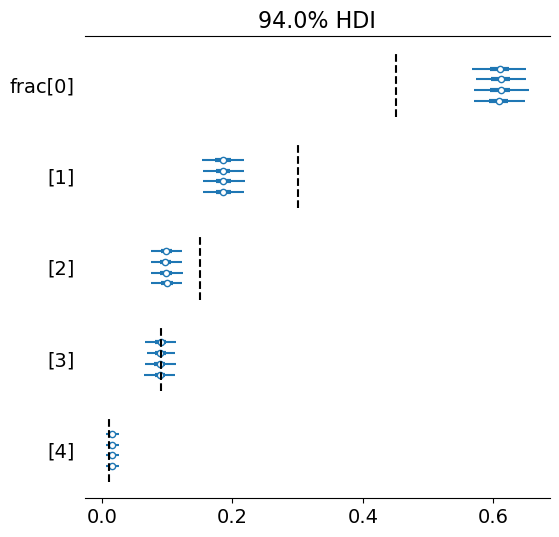

In [8]:
az.plot_forest(trace_multinomial, var_names=["frac"])
for j, (y_tick, frac_j) in enumerate(zip(plt.gca().get_yticks(), reversed(true_frac))):
    plt.vlines(frac_j, ymin=y_tick - 0.45, ymax=y_tick + 0.45, color="black", linestyle="--")

In [12]:
with model_multinomial:
    ppc = pm.sample_posterior_predictive(
        trace=trace_multinomial
    )

# Concatenate with InferenceData object
trace_multinomial.extend(az.from_dict(posterior_predictive=ppc))

Sampling: [counts]


TypeError: DictConverter.posterior_predictive is not a dictionary